In [1]:
import os, pickle
import pandas as pd
import numpy as np
import plotly.express as px
from pycaret.regression import *
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook, Workbook
import src.paychex_ml.data_loader as dl
import src.paychex_ml.models as models

warnings.filterwarnings("ignore")

In [2]:
## Change the project path
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"

In [3]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'
# This is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5
# This is how many features you want to keep in the final model
features_threshold = 10

In [4]:
# Set manually date if is necessary
model_run_date = datetime.today().strftime('%Y%m%d')
#model_run_date = '20220504'

In [5]:
# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
# target_col = 'Payroll blended products'
# has_drivers = True
# target_col = 'W-2 Revenue'
# has_drivers = False
# target_col = 'Delivery Revenue'
# has_drivers = False
# target_col = 'ASO Allocation'
# has_drivers = False
# target_col = 'Other Processing Revenue'
# has_drivers = False
# target_col = 'SurePayroll.'
# has_drivers = True
# target_col = 'Total international'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
# target_col = '401K Fee Revenue'
# has_drivers = True
# target_col = '401K Asset fee & BP Revenue'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total ASO Revenue
# ------------------------------------------------------------------------------------- #
# target_col = 'HR Solutions (PEO)'
# has_drivers = False
# target_col = 'ASO Revenue - Oasis'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Online Services
# ------------------------------------------------------------------------------------- #
# target_col = 'HR Online'
# has_drivers = False
# target_col = 'Time & Attendance'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Other Management Solutions
# ------------------------------------------------------------------------------------- #
# target_col = 'Total Paychex Advance'
# has_drivers = True
# target_col = 'Full Service Unemployment Revenue'
# has_drivers = True
# target_col = 'ESR Revenue'
# has_drivers = True
# target_col = 'Cafeteria Plans Revenue'
# has_drivers = True
# target_col = 'Benetrac'
# has_drivers = True
# target_col = 'Emerging Products'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total PEO
# ------------------------------------------------------------------------------------- #
# target_col = 'Total PEO'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Insurance Services
# ------------------------------------------------------------------------------------- #
# target_col = 'Workers Comp - Payment Services'
# has_drivers = True
# target_col = 'Health Benefits'
# has_drivers = True

# target_col = 'Interest on Funds Held for Clients'
# has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total Level 1
# ------------------------------------------------------------------------------------- #
target_col = 'Total Payroll Revenue.'
has_drivers = True
# target_col = 'Total 401k'
# has_drivers = True
# target_col = 'Total ASO Revenue'
# has_drivers = False
# target_col = 'Total Online Services'
# has_drivers = True
# target_col = 'Other Management Solutions'
# has_drivers = True
# target_col = 'Total Insurance Services'
# has_drivers = True

# ------------------------------------------------------------------------------------- #
# Total Level 2
# ------------------------------------------------------------------------------------- #
# target_col = 'Total Revenue'
# has_drivers = False



In [22]:
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [plan_col,fcst_col,ml_col,uts_col]
has_actuals = True
feature_selection = 'ml_features'
level = 1

In [7]:
# Get the full data frame and combine with drivers
#all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)

In [8]:
file_path = proyect_path+"/data/clean/table_predictable.csv"
all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, level=level)

In [9]:
drive_path = proyect_path+"/data/clean/table_drivers.csv"
#driv_df_ = pd.read_csv(file_path, dtype={'Period':str, 'Calendar Date': str})
#driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, file_path)

In [10]:
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
    #driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')

In [11]:
external_path = proyect_path+"/data/external/external_data_fred.csv"
ext_df = pd.read_csv(external_path, dtype={'date': str})\
    .rename(columns={'date': 'Calendar Date'})
#ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

In [12]:
model_path = proyect_path+"/data/models/"+model_run_date
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print("Directory created")

Directory created


In [13]:
# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

Shape of the training dataframe:
(72, 1691)
Shape of the testing dataframe:
(12, 1691)
Shape of the combination dataframe:
(84, 1691)


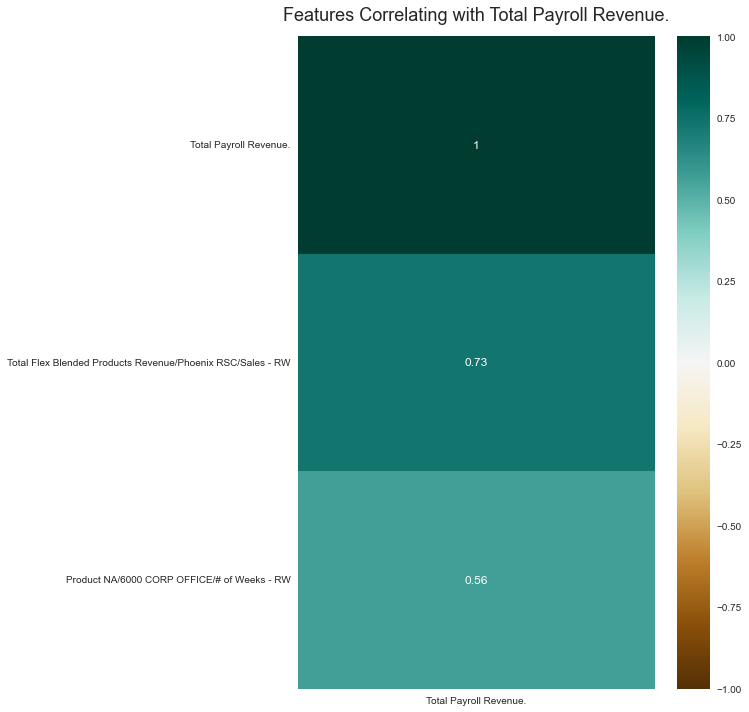

In [49]:
feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
corr_df = corr_df[corr_df[target_col].abs() >= correlation_threshold].sort_values(target_col, ascending=False)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

In [47]:
corr_df

,Feature,Total Payroll Revenue.
0,Total Payroll Revenue.,1.000000
1,PR PRODUCT/1502 SP ETAP/Sales - RW,0.718421
2,Product NA/6000 CORP OFFICE/# of Weeks - RW,0.563563
3,Total Advantage Blended Products Revenue/ADVAN...,-0.709670
4,Total Advantage Blended Products Revenue/ADVAN...,0.704199
...,...,...
63,Total Preview Blended Products Revenue/0476 NO...,0.582318
64,Total Preview Blended Products Revenue/0485 SA...,-0.509149
65,Total Preview Blended Products Revenue/0485 SA...,0.535663
66,W-2 100/1502 SP ETAP/Revenue / Billable PR,0.509849


In [15]:
# Get a list of the features based on correlation
corr_df = corr_df.rename_axis('Feature').reset_index()
corr_feature_cols = corr_df['Feature'].tolist()
corr_feature_cols.remove(target_col)
#print(corr_feature_cols)

In [16]:
# run auto ml and get the most important features
best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,10128614.8333,356680444062378.6875,15328093.5000,0.3436,0.0878,0.0599,0.2800
et,Extra Trees Regressor,10681760.9644,401429470166082.5000,16575289.8741,0.2159,0.0965,0.0629,0.1133
gbr,Gradient Boosting Regressor,10717780.9601,389903491008185.6875,16181675.3361,0.2711,0.0932,0.0634,0.1467
rf,Random Forest Regressor,11224369.1778,400448853096891.9375,16495599.6653,0.2310,0.0951,0.0667,0.1100
ada,AdaBoost Regressor,11904938.6655,431101590920097.9375,17488328.7767,0.0758,0.1023,0.0710,0.1033
lightgbm,Light Gradient Boosting Machine,12122363.6687,453920207643426.7500,18439973.9368,-0.1074,0.1067,0.0713,0.0467
dummy,Dummy Regressor,13084745.0000,536629733927594.6875,19613630.0000,-0.1731,0.1146,0.0772,0.0100
dt,Decision Tree Regressor,13190466.3704,469635113177398.5000,18896120.5779,-0.2483,0.1132,0.0795,0.0267
omp,Orthogonal Matching Pursuit,13200289.2538,462077581101923.0000,20274250.8802,-1.3849,0.1328,0.0808,1.0733
llar,Lasso Least Angle Regression,13216918.0070,458826955010594.0000,19567657.9892,-0.5585,0.1204,0.0804,1.5500


<class 'xgboost.sklearn.XGBRegressor'>


In [23]:
 # ml_features or corr_features
if feature_selection == 'ml_features':
    ml_features = models.get_important_features('xgboost', features_threshold)
    feature_cols = ml_features['Feature'].tolist()
elif feature_selection == 'corr_features':
    corr_df = corr_df.rename_axis('Feature').reset_index()
    feature_cols = corr_df['Feature'].tolist()
    #feature_cols.remove(target_col)
else:
    print("No feature selection. This could take a while!")

In [24]:
# ml_features = models.get_important_features('xgboost', features_threshold)
# ml_feature_cols = ml_features['Feature'].tolist()

if len(ml_features.index) != 0:
    # plot the most important features
    fig = px.bar(ml_features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance',
                 y='Feature',
                 orientation='h',
                 title='Feature Importance Plot')
    fig.show()

In [26]:
with open(model_path + '/{}_features'.format(target_col), "wb") as fp:   #Pickling
    pickle.dump(feature_cols, fp)

In [27]:
# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #


# Here we need to figure out which set of features we want to use
# ml_features or corr_features
#feature_cols = ml_feature_cols
#feature_cols = corr_feature_cols

#feature_cols = ml_feature_cols
keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
llar,Lasso Least Angle Regression,10211851.5787,321423287720863.3125,15988596.3912,-0.0200,0.0943,0.0611,0.0100
gbr,Gradient Boosting Regressor,10377468.5812,339663536594273.9375,15284868.7201,0.3291,0.0883,0.0622,0.0200
rf,Random Forest Regressor,10428431.9467,353256413179667.5000,15483397.4658,0.3216,0.0900,0.0626,0.0867
xgboost,Extreme Gradient Boosting,10629665.0000,331207756393130.6875,15925111.3333,0.1452,0.0924,0.0633,0.0933
et,Extra Trees Regressor,10684194.1926,333887685395666.4375,15465700.4474,0.2659,0.0895,0.0640,0.0600
ada,AdaBoost Regressor,10754602.9883,353234794451631.0625,15772164.3121,0.2603,0.0912,0.0645,0.0333
omp,Orthogonal Matching Pursuit,11228813.2725,306181776311994.1875,15797356.4465,0.0543,0.0913,0.0684,0.0067
lr,Linear Regression,11367810.0000,359763506364416.0000,17713432.6667,-0.3451,0.1056,0.0700,1.3300
ridge,Ridge Regression,11594830.3333,349127070187520.0000,17512253.0000,-0.3574,0.1023,0.0716,0.7600
dt,Decision Tree Regressor,11776064.0000,351543311415343.4375,16389862.1809,0.0878,0.0974,0.0724,0.0100


<class 'sklearn.linear_model._least_angle.LassoLars'>


In [28]:
pipeline, name = save_model(best, model_path + '/{}_model'.format(target_col))

Transformation Pipeline and Model Successfully Saved


In [29]:
# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

In [30]:
act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
act_df = act_df[['Calendar Date', target_col]]
act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])

In [31]:
# create the future predictions dataframe
if has_actuals:
    pred_df, _ = models.run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window, ci=False)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df = pred_df.rename(columns={'Label':ml_col})[['Calendar Date', ml_col]]
    concat_df = pd.merge(act_df, pred_df ,on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, type='plan', level=level)
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path,
                                type='forecast',
                                forecast_type=forecast_type,
                                level=level)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

############################  Running Auto ARIMA for Total Flex Blended Products Revenue/Phoenix RSC/Sales - RW   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=876.170, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=925.889, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=895.167, Time=0.23 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=875.036, Time=0.31 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=886.854, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=920.171, Time=0.10 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=876.275, Time=0.43 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=892.699, Time=0.13 sec
 ARIMA(1,1,2)(0,1,1)[12]             :

In [32]:
# run UTS
uts_df = comb_df[['Calendar Date', target_col]]
uts_df, uts_model = models.run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window, ci=True)
uts_df.rename(columns={target_col:uts_col}, inplace=True)

############################  Running Auto ARIMA for Total Payroll Revenue.   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2592.607, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2620.949, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2599.710, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2591.230, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2601.867, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2590.121, Time=0.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2596.571, Time=0.09 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2590.557, Time=0.38 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2591.151, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2589.152, Time=0.43 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2610.714, Time=0.18 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2590.372, Time=0.37 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=259

In [33]:
with open(model_path + '/{}_uts_model.pkl'.format(target_col), 'wb') as pkl:
    pickle.dump(uts_model, pkl)

In [34]:
concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')

In [35]:
# combine all data together
concat_df = pd.concat([comb_df[['Calendar Date', target_col]],concat_df], axis=0)

In [36]:
# show plot
fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
fig.show()

In [37]:
# compute mape_df
mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
mape_df = models.compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
mape_df = mape_df.rename(index={True:'MAPE'})
mape_df = pd.concat([mape_df.reset_index(drop=True), uts_df], axis=1)

In [38]:
mape_df

,Calendar Date,Total Payroll Revenue.,Total Payroll Revenue. - Plan,Total Payroll Revenue. - Plan - APE,Total Payroll Revenue. - 2+10 Forecast,Total Payroll Revenue. - 2+10 Forecast - APE,Total Payroll Revenue. - ML Predicted,Total Payroll Revenue. - ML Predicted - APE,Total Payroll Revenue. - UTS Predicted,Total Payroll Revenue. - UTS Predicted - APE,Calendar Date,Total Payroll Revenue. - UTS Predicted,Lower CI,Upper CI
0,2021-06-01 00:00:00,1.575253e+08,1.545152e+08,0.019109,1.575253e+08,0.000000,1.707101e+08,0.083700,1.497961e+08,0.049067,2021-06-01,1.497961e+08,1.131105e+08,1.864817e+08
1,2021-07-01 00:00:00,1.603055e+08,1.599829e+08,0.002013,1.603055e+08,0.000000,1.759330e+08,0.097485,1.593652e+08,0.005866,2021-07-01,1.593652e+08,1.174609e+08,2.012694e+08
2,2021-08-01 00:00:00,1.581824e+08,1.573212e+08,0.005445,1.598271e+08,0.010397,1.591932e+08,0.006390,1.497247e+08,0.053468,2021-08-01,1.497247e+08,1.031833e+08,1.962660e+08
3,2021-09-01 00:00:00,1.636794e+08,1.535862e+08,0.061664,1.549976e+08,0.053042,1.728200e+08,0.055844,1.556959e+08,0.048775,2021-09-01,1.556959e+08,1.049393e+08,2.064525e+08
4,2021-10-01 00:00:00,1.582147e+08,1.496698e+08,0.054009,1.501665e+08,0.050869,1.615822e+08,0.021285,1.628828e+08,0.029505,2021-10-01,1.628828e+08,1.082352e+08,2.175305e+08
5,2021-11-01 00:00:00,1.654184e+08,1.536935e+08,0.070881,1.552788e+08,0.061297,1.564902e+08,0.053973,1.534241e+08,0.072509,2021-11-01,1.534241e+08,9.514463e+07,2.117036e+08
6,2021-12-01 00:00:00,1.902936e+08,1.684740e+08,0.114663,1.693045e+08,0.110299,1.843657e+08,0.031151,1.778874e+08,0.065195,2021-12-01,1.778874e+08,1.161895e+08,2.395853e+08
7,2022-01-01 00:00:00,2.589241e+08,2.432610e+08,0.060493,2.435884e+08,0.059229,2.198186e+08,0.151031,2.371740e+08,0.084002,2022-01-01,2.371740e+08,1.722374e+08,3.021107e+08
8,NaN,NaN,NaN,0.048534,NaN,0.043141,NaN,0.062607,NaN,0.051048,NaT,NaN,NaN,NaN


In [39]:
metadata_path = proyect_path + "/data/metadata/"
mape_path = metadata_path + model_run_date + "_mape.xlsx"
if os.path.exists(mape_path):
    book = load_workbook(mape_path)
else:
    book = Workbook()
with pd.ExcelWriter(mape_path, engine = 'openpyxl') as writer:
    writer.book = book
    mape_df.to_excel(writer, sheet_name = target_col[0:30], index=False)

In [40]:
concat_df[concat_df['Calendar Date'] >= pred_start_dt]

,Calendar Date,Total Payroll Revenue.,Total Payroll Revenue. - ML Predicted,Total Payroll Revenue. - Plan,Total Payroll Revenue. - 2+10 Forecast,Total Payroll Revenue. - UTS Predicted,Lower CI,Upper CI
0,2021-06-01,1.575253e+08,1.707101e+08,1.545152e+08,1.575253e+08,1.497961e+08,1.131105e+08,1.864817e+08
1,2021-07-01,1.603055e+08,1.759330e+08,1.599829e+08,1.603055e+08,1.593652e+08,1.174609e+08,2.012694e+08
2,2021-08-01,1.581824e+08,1.591932e+08,1.573212e+08,1.598271e+08,1.497247e+08,1.031833e+08,1.962660e+08
3,2021-09-01,1.636794e+08,1.728200e+08,1.535862e+08,1.549976e+08,1.556959e+08,1.049393e+08,2.064525e+08
4,2021-10-01,1.582147e+08,1.615822e+08,1.496698e+08,1.501665e+08,1.628828e+08,1.082352e+08,2.175305e+08
5,2021-11-01,1.654184e+08,1.564902e+08,1.536935e+08,1.552788e+08,1.534241e+08,9.514463e+07,2.117036e+08
6,2021-12-01,1.902936e+08,1.843657e+08,1.684740e+08,1.693045e+08,1.778874e+08,1.161895e+08,2.395853e+08
7,2022-01-01,2.589241e+08,2.198186e+08,2.432610e+08,2.435884e+08,2.371740e+08,1.722374e+08,3.021107e+08


In [41]:
predictions_path = proyect_path+"/data/predictions/"+model_run_date
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)
    print("Directory created")

Directory created


In [42]:
df_write = concat_df.rename(columns={target_col: 'Actual',
                           ml_col: 'ML Predicted',
                           uts_col: 'UTS Predicted',
                           plan_col: 'Plan',
                           fcst_col:' Forecast'})

In [43]:
df_write['Item'] = target_col

In [44]:
df_write

,Calendar Date,Actual,ML Predicted,Plan,Forecast,UTS Predicted,Lower CI,Upper CI,Item
0,2014-06-01,1.301339e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Payroll Revenue.
1,2014-07-01,1.622501e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Payroll Revenue.
2,2014-08-01,1.299953e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Payroll Revenue.
3,2014-09-01,1.246127e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Payroll Revenue.
4,2014-10-01,1.660720e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Payroll Revenue.
...,...,...,...,...,...,...,...,...,...
3,2021-09-01,1.636794e+08,1.728200e+08,1.535862e+08,1.549976e+08,1.556959e+08,1.049393e+08,2.064525e+08,Total Payroll Revenue.
4,2021-10-01,1.582147e+08,1.615822e+08,1.496698e+08,1.501665e+08,1.628828e+08,1.082352e+08,2.175305e+08,Total Payroll Revenue.
5,2021-11-01,1.654184e+08,1.564902e+08,1.536935e+08,1.552788e+08,1.534241e+08,9.514463e+07,2.117036e+08,Total Payroll Revenue.
6,2021-12-01,1.902936e+08,1.843657e+08,1.684740e+08,1.693045e+08,1.778874e+08,1.161895e+08,2.395853e+08,Total Payroll Revenue.


In [45]:
df_write.to_parquet(predictions_path+"/"+target_col.replace(" ","")+".parquet")

In [158]:
df = pd.read_parquet("C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast/data/predictions/20220509")

In [159]:
df

,Calendar Date,Item,Actual,ML Predicted,UTS Predicted,Plan,Forecast,Lower CI,Upper CI
0,2021-06-01,Delivery Revenue,7.829827e+06,8.742005e+06,7.621582e+06,7.486713e+06,7.829827e+06,5.679662e+06,9.563501e+06
1,2021-07-01,Delivery Revenue,1.243936e+07,1.289055e+07,1.218767e+07,1.261072e+07,1.243936e+07,1.005493e+07,1.432041e+07
2,2021-08-01,Delivery Revenue,7.622602e+06,7.869987e+06,7.427974e+06,7.556542e+06,7.682000e+06,4.843065e+06,1.001288e+07
3,2021-09-01,Delivery Revenue,7.779041e+06,7.976084e+06,7.893044e+06,6.818278e+06,7.149703e+06,5.066063e+06,1.072002e+07
4,2021-10-01,Delivery Revenue,1.126827e+07,1.287066e+07,1.247308e+07,1.174251e+07,1.122409e+07,9.354347e+06,1.559181e+07
5,2021-11-01,Delivery Revenue,7.617424e+06,7.695706e+06,7.406496e+06,6.938894e+06,7.147250e+06,4.056574e+06,1.075642e+07
6,2021-12-01,Delivery Revenue,8.212787e+06,8.042708e+06,8.094190e+06,7.564224e+06,7.716521e+06,4.510080e+06,1.167830e+07
7,2022-01-01,Delivery Revenue,2.243552e+07,2.102415e+07,2.258278e+07,2.262883e+07,2.207458e+07,1.878818e+07,2.637738e+07
8,2021-06-01,Payroll blended products,1.142380e+08,1.069185e+08,1.145630e+08,1.134306e+08,1.142380e+08,9.281367e+07,1.363124e+08
9,2021-07-01,Payroll blended products,1.131859e+08,1.110458e+08,1.157635e+08,1.143207e+08,1.131859e+08,9.176588e+07,1.397611e+08
